In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2025-11-03 21:53:21.554888: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-03 21:53:21.612341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-03 21:53:22.922031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Rutas
data_dir = "./Datasets/flower_photos"
csv_path = os.path.join(data_dir, "all_labels.csv")
img_dir = os.path.join(data_dir, "flowers")

# Leer el CSV
df = pd.read_csv(csv_path)

# Si las clases son texto, convertirlas a números (0,1,2)
class_names = sorted(df["label"].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}
df["label"] = df["label"].map(class_to_index)


print("Clases detectadas:", class_to_index)

Clases detectadas: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [3]:

# Dividir en entrenamiento (80%) y validación (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Función para cargar una imagen desde su ruta y etiqueta
def load_image(image_name, label):
    img_path = tf.strings.join([img_dir, "/", image_name])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    return img, label

In [4]:
# Crear datasets de TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((train_df["file_name"].values, train_df["label"].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["file_name"].values, val_df["label"].values))

train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

2025-11-03 21:53:23.966021: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Normalización y aumento
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# Aplicar aumento y normalización
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

# Configurar rendimiento
train_ds = train_ds.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:

# Modelo convolucional
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    #Conv2D(32, (3,3), activation='relu'),
    #MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # número de clases automático
])

/home/erich/Analista en Computación/Inteligencia Artificial/Practicos-IA/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.4530 - loss: 1.3144 - val_accuracy: 0.3867 - val_loss: 1.3686
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.5238 - loss: 1.1829 - val_accuracy: 0.4475 - val_loss: 1.3156
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.5704 - loss: 1.1051 - val_accuracy: 0.5359 - val_loss: 1.1541
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 322ms/step - accuracy: 0.6043 - loss: 1.0342 - val_accuracy: 0.6409 - val_loss: 0.9291
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.6091 - loss: 0.9993 - val_accuracy: 0.6174 - val_loss: 0.9156
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 321ms/step - accuracy: 0.6336 - loss: 0.9617 - val_accuracy: 0.5704 - val_loss: 1.0596
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.6592 - loss: 0.9312 - val_accuracy: 0.6450 - val_loss: 0.9187
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.6564 - loss: 0.9059 - val_accu

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7348 - loss: 0.6834

🔹 Resultados finales:
Pérdida (loss): 0.6834
Precisión (accuracy): 0.7348


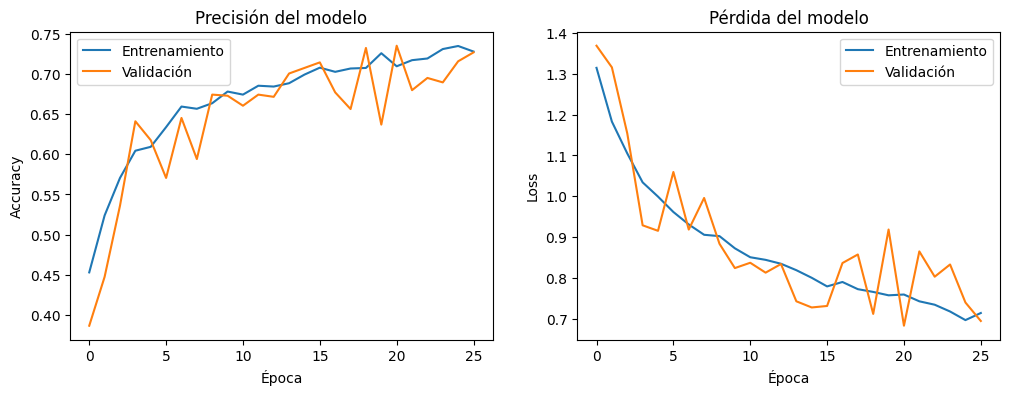

In [8]:
# Evaluación
results = model.evaluate(val_ds)
print("\n🔹 Resultados finales:")
print(f"Pérdida (loss): {results[0]:.4f}")
print(f"Precisión (accuracy): {results[1]:.4f}")

# Gráficos
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()